In [37]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import os

In [38]:
def run_lightgbm(train_path, test_path, label, output_dir):

    print(f"\n===== LIGHTGBM – {label.upper()} =====")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    train = pd.read_csv(train_path, parse_dates=["timestamp"])
    test  = pd.read_csv(test_path,  parse_dates=["timestamp"])

    train = train.sort_values("timestamp")
    test  = test.sort_values("timestamp")

    FEATURES = [
        "hour_of_day",
        "day_of_week",
        "hour_sin",
        "hour_cos",
        "is_burst",
        "burst_ratio",
        "lag_requests_5m",
        "lag_requests_15m",
        "rolling_max_1h",
        "rolling_mean_1h",
        "lag_requests_6h",
        "lag_requests_1d"
    ]

    TARGET = "requests_count"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    # ======================
    # LIGHTGBM DATASET
    # ======================
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_test, y_test, reference=lgb_train)

    params = {
        "objective": "regression",
        "metric": "mae",
        "learning_rate": 0.05,
        "max_depth": 6,
        "num_leaves": 63,
        "min_data_in_leaf": 62,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
        "verbosity": -1,
        "seed": 42
    }

    # ======================
    # TRAIN MODEL
    # ======================
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_valid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=0)
        ]
    )

    # ======================
    # PREDICTION
    # ======================
    forecast = model.predict(X_test)

    # ======================
    # METRICS
    # ======================
    mae  = mean_absolute_error(y_test, forecast)
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    smape = np.mean(
        2 * np.abs(forecast - y_test) /
        (np.abs(y_test) + np.abs(forecast) + 1e-6)
    ) * 100

    print("🎯 MODEL PERFORMANCE (TEST SET)")
    print(f"MAE   : {mae:.2f}")
    print(f"RMSE  : {rmse:.2f}")
    print(f"sMAPE : {smape:.2f}%")

    # ======================
    # SAVE MODEL
    # ======================
    model_path = f"{output_dir}/lightgbm_{label}_model.txt"
    model.save_model(model_path)
    print(f"💾 Saved model: {model_path}")

    # ======================
    # EXPORT PREDICTIONS
    # ======================
    pred_df = pd.DataFrame({
        "actual": y_test.values,
        "predicted": forecast,
        "error": y_test.values - forecast,
        "abs_error": np.abs(y_test.values - forecast),
        "error_pct": np.abs(y_test.values - forecast) / (y_test.values + 1e-6) * 100
    })

    pred_path = f"{output_dir}/lightgbm_{label}_predictions.csv"
    pred_df.to_csv(pred_path, index=False)
    print(f"📊 Saved predictions: {pred_path}")



    # ======================
    # SAVE PLOT
    # ======================
    plt.figure(figsize=(15,4))
    plt.plot(test["timestamp"], y_test, label="Actual", linewidth=2)
    plt.plot(test["timestamp"], forecast, label="Forecast", alpha=0.8)
    plt.title(f"Actual vs Forecast – LightGBM ({label.upper()})")
    plt.xlabel("Time")
    plt.ylabel("Requests")
    plt.legend()
    plt.grid(alpha=0.3)

    fig_path = f"{output_dir}/lightgbm_{label}_forecast.png"
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

    print(f"📈 Saved figure: {fig_path}")

    return model


===== LIGHTGBM – 1M =====
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's l1: 10.5007
🎯 MODEL PERFORMANCE (TEST SET)
MAE   : 10.50
RMSE  : 13.90
sMAPE : 31.35%
💾 Saved model: models/lightgbm_1m_model.txt
📊 Saved predictions: models/lightgbm_1m_predictions.csv


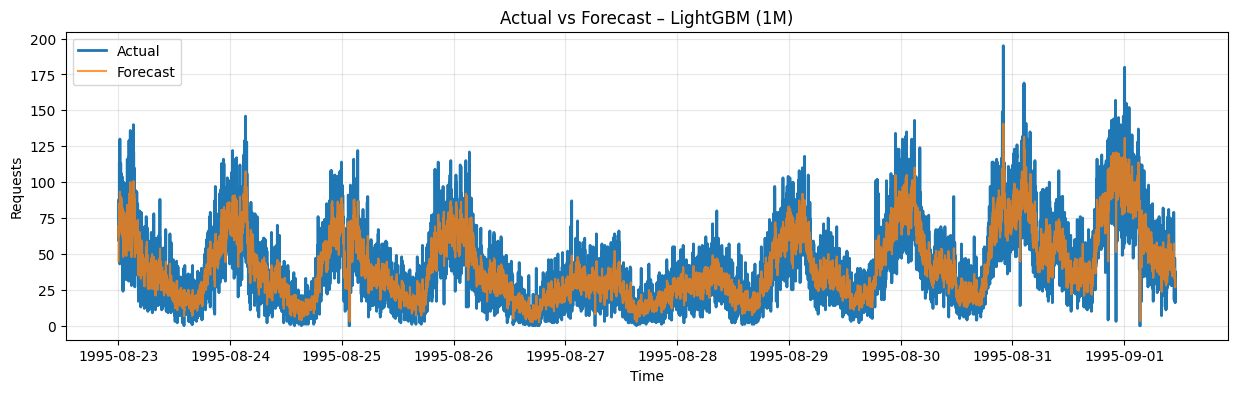

📈 Saved figure: models/lightgbm_1m_forecast.png


In [39]:
model_1m = run_lightgbm(
    train_path="../datasets/train_1m_autoscaling.csv",
    test_path="../datasets/test_1m_autoscaling.csv",
    label="1m",
    output_dir="models"
)


===== LIGHTGBM – 5M =====
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's l1: 34.4935
🎯 MODEL PERFORMANCE (TEST SET)
MAE   : 34.49
RMSE  : 46.05
sMAPE : 20.12%
💾 Saved model: models/lightgbm_5m_model.txt
📊 Saved predictions: models/lightgbm_5m_predictions.csv


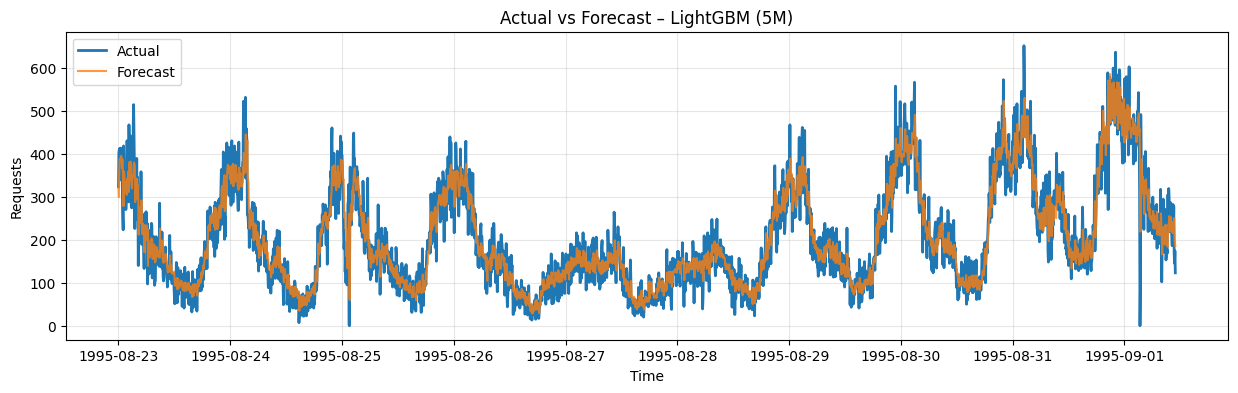

📈 Saved figure: models/lightgbm_5m_forecast.png


In [40]:
model_5m = run_lightgbm(
    train_path="../datasets/train_5m_autoscaling.csv",
    test_path="../datasets/test_5m_autoscaling.csv",
    label="5m",
    output_dir="models"
)


===== LIGHTGBM – 15M =====
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[185]	valid_0's l1: 82.3992
🎯 MODEL PERFORMANCE (TEST SET)
MAE   : 82.40
RMSE  : 113.43
sMAPE : 15.30%
💾 Saved model: models/lightgbm_15m_model.txt
📊 Saved predictions: models/lightgbm_15m_predictions.csv


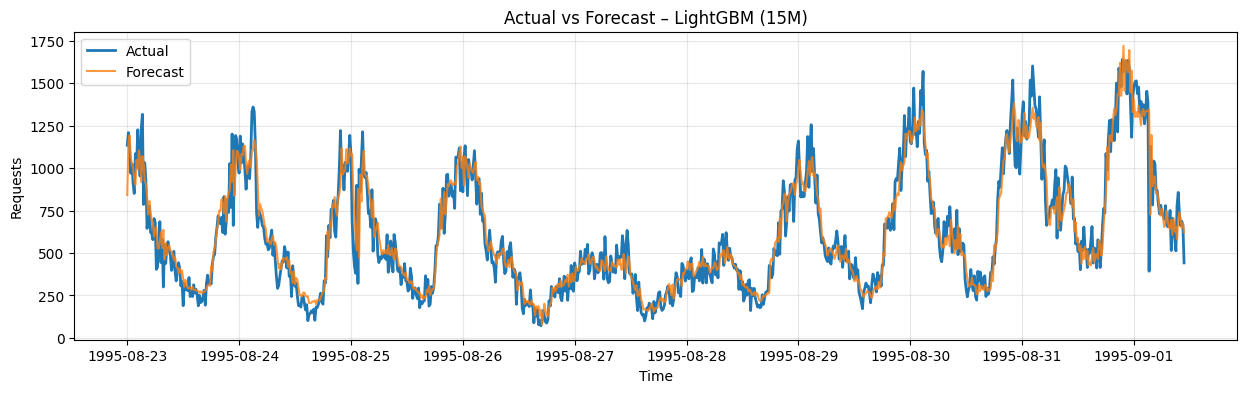

📈 Saved figure: models/lightgbm_15m_forecast.png


In [41]:
model_15m = run_lightgbm(
    train_path="../datasets/train_15m_autoscaling.csv",
    test_path="../datasets/test_15m_autoscaling.csv",
    label="15m",
    output_dir="models"
)

In [42]:
# Summary of saved models
print("\n" + "="*60)
print("📦 ALL LIGHTGBM MODELS SAVED")
print("="*60)
print("✅ LightGBM 1m  model: models/lightgbm_1m_model.txt")
print("✅ LightGBM 5m  model: models/lightgbm_5m_model.txt")
print("✅ LightGBM 15m model: models/lightgbm_15m_model.txt")
print("="*60)


📦 ALL LIGHTGBM MODELS SAVED
✅ LightGBM 1m  model: models/lightgbm_1m_model.txt
✅ LightGBM 5m  model: models/lightgbm_5m_model.txt
✅ LightGBM 15m model: models/lightgbm_15m_model.txt
